In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision scikit-learn scikit-image pandas numpy matplotlib skrebate tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=08be80a2fdf461151d5f2a79f28c699f5d2db6194e54d1cfa064d56a060fe6c9
  Stored in directory: /root/.cache/pip/wheels/03/4c/36/bc6b70d88998635e0ec0e617d15cd97483f5008d6bb77c1c7a
Successfully built skrebate


In [3]:
# To Import Libraries

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skrebate import ReliefF
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


In [4]:
# Dataset Path Input

DATASET_PATH = input("/content/drive/MyDrive/urop_dataset")

TRAIN_DIR = os.path.join(DATASET_PATH, "Training")
TEST_DIR = os.path.join(DATASET_PATH, "Testing")

/content/drive/MyDrive/urop_dataset/content/drive/MyDrive/urop_dataset


In [5]:
# Geometric Mean Filter

def geometric_mean_filter(img, kernel_size=3):
    img = img.astype(np.float64) + 1e-5
    log_img = np.log(img)
    mean_log = cv2.blur(log_img, (kernel_size, kernel_size))
    gmean = np.exp(mean_log)
    return np.uint8(np.clip(gmean, 0, 255))

In [6]:
# AlexNet Feature Extractor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = models.alexnet(pretrained=True)
alexnet.classifier = torch.nn.Sequential(*list(alexnet.classifier.children())[:-1])  # remove last FC
alexnet.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def extract_alexnet_features(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = alexnet(img)
    return features.cpu().numpy().flatten()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 152MB/s]


In [7]:
# Load Data Helper

def load_data_from_folder(folder_path):
    X, y = [], []
    for label in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, label)
        if not os.path.isdir(class_dir):
            continue
        for file in tqdm(os.listdir(class_dir), desc=f"Processing {label}"):
            path = os.path.join(class_dir, file)
            try:
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = geometric_mean_filter(img)
                temp_path = "temp_img.jpg"
                cv2.imwrite(temp_path, img)
                feats = extract_alexnet_features(temp_path)
                X.append(feats)
                y.append(label)
            except Exception as e:
                print(f" Error with {path}: {e}")
    return np.array(X), np.array(y)

In [8]:
# Load Training & Testing Data

print("\n Loading TRAINING data...")
X_train, y_train = load_data_from_folder(TRAIN_DIR)

print("\n Loading TESTING data...")
X_test, y_test = load_data_from_folder(TEST_DIR)

print(f"\n Training data shape: {X_train.shape}, Labels: {len(y_train)}")
print(f" Testing data shape: {X_test.shape}, Labels: {len(y_test)}")


 Loading TRAINING data...


Processing meningioma: 100%|██████████| 1339/1339 [02:34<00:00,  8.67it/s]



 Loading TESTING data...


Processing glioma: 100%|██████████| 300/300 [00:40<00:00,  7.49it/s]


 Training data shape: (5713, 4096), Labels: 5713
 Testing data shape: (1311, 4096), Labels: 1311


In [9]:
 # Label Encoding

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [10]:
# Pre-Reduction + ReliefF Feature Selection

from sklearn.decomposition import PCA

print("\n Step 1: Pre-reducing features before ReliefF...")
pca = PCA(n_components=256)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)


 Step 1: Pre-reducing features before ReliefF...


In [11]:
from skrebate import ReliefF

print("\n Step 2: Running ReliefF on reduced features...")
relief = ReliefF(n_neighbors=10, n_features_to_select=100)
X_train_sel = relief.fit_transform(X_train_reduced, y_train_enc)
X_test_sel = relief.transform(X_test_reduced)



 Step 2: Running ReliefF on reduced features...


In [12]:
# Feature Scaling

scaler = StandardScaler()
X_train_sel = scaler.fit_transform(X_train_sel)
X_test_sel = scaler.transform(X_test_sel)

In [13]:
# SVM Classifier

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print("\n Training SVM...")
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_sel, y_train_enc)
svm_preds = svm_model.predict(X_test_sel)

cm = confusion_matrix(y_test_enc, svm_preds)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

acc_svm = accuracy_score(y_test_enc, svm_preds)
sen_svm = np.mean(TP / (TP + FN))
spe_svm = np.mean(TN / (TN + FP))
pre_svm = precision_score(y_test_enc, svm_preds, average='macro')
rec_svm = recall_score(y_test_enc, svm_preds, average='macro')

print(f" SVM Accuracy: {acc_svm:.4f}")


 Training SVM...
 SVM Accuracy: 0.9428


In [14]:
# KNN Classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print("\n Training KNN...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_sel, y_train_enc)
knn_preds = knn_model.predict(X_test_sel)

cm = confusion_matrix(y_test_enc, knn_preds)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

acc_knn = accuracy_score(y_test_enc, knn_preds)
sen_knn = np.mean(TP / (TP + FN))
spe_knn = np.mean(TN / (TN + FP))
pre_knn = precision_score(y_test_enc, knn_preds, average='macro')
rec_knn = recall_score(y_test_enc, knn_preds, average='macro')

print(f" KNN Accuracy: {acc_knn:.4f}")


 Training KNN...
 KNN Accuracy: 0.9085


In [15]:
#  Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print("\n Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_sel, y_train_enc)
rf_preds = rf_model.predict(X_test_sel)

cm = confusion_matrix(y_test_enc, rf_preds)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

acc_rf = accuracy_score(y_test_enc, rf_preds)
sen_rf = np.mean(TP / (TP + FN))
spe_rf = np.mean(TN / (TN + FP))
pre_rf = precision_score(y_test_enc, rf_preds, average='macro')
rec_rf = recall_score(y_test_enc, rf_preds, average='macro')

print(f" Random Forest Accuracy: {acc_rf:.4f}")


 Training Random Forest...
 Random Forest Accuracy: 0.9291


In [16]:
# Naive Bayes Classifier

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print("\n Training Naive Bayes...")
nb_model = GaussianNB()
nb_model.fit(X_train_sel, y_train_enc)
nb_preds = nb_model.predict(X_test_sel)

cm = confusion_matrix(y_test_enc, nb_preds)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

acc_nb = accuracy_score(y_test_enc, nb_preds)
sen_nb = np.mean(TP / (TP + FN))
spe_nb = np.mean(TN / (TN + FP))
pre_nb = precision_score(y_test_enc, nb_preds, average='macro')
rec_nb = recall_score(y_test_enc, nb_preds, average='macro')

print(f" Naive Bayes Accuracy: {acc_nb:.4f}")


 Training Naive Bayes...
 Naive Bayes Accuracy: 0.7292


In [17]:
# Comparision and Conclusion for Classifiers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

models = ['SVM', 'KNN', 'Random Forest', 'Naive Bayes']
accuracy = [acc_svm, acc_knn, acc_rf, acc_nb]
sensitivity = [sen_svm, sen_knn, sen_rf, sen_nb]
specificity = [spe_svm, spe_knn, spe_rf, spe_nb]
precision = [pre_svm, pre_knn, pre_rf, pre_nb]
recall = [rec_svm, rec_knn, rec_rf, rec_nb]

results_df = pd.DataFrame({
    'Classifier': models,
    'Accuracy': accuracy,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Precision': precision,
    'Recall': recall
})

results_df = results_df.round(4)
print("\n PERFORMANCE SUMMARY TABLE:\n")
print(results_df)

best_idx = np.argmax(accuracy)
best_classifier = models[best_idx]
best_acc = accuracy[best_idx]

print("\n BEST PERFORMING CLASSIFIER:")
print(f"{best_classifier} achieved the highest accuracy of {best_acc*100:.2f}%.")

print(f"\n Detailed Observation:")
print(f"- {best_classifier} shows the strongest overall performance among the four algorithms.")
print(f"- The accuracy metric (TP+TN)/(TP+TN+FP+FN) is the main indicator for comparison.")
print(f"- Sensitivity (TP/(TP+FN)) reflects the model’s ability to correctly detect tumor cases.")
print(f"- Specificity (TN/(TN+FP)) measures how well it identifies non-tumor cases.")
print(f"- Precision and Recall balance false positives and false negatives respectively.")
print(f"\nBased on the above results, {best_classifier} is most suitable for MRI brain tumor classification in this dataset.")


 PERFORMANCE SUMMARY TABLE:

      Classifier  Accuracy  Sensitivity  Specificity  Precision  Recall
0            SVM    0.9428       0.9385       0.9810     0.9440  0.9385
1            KNN    0.9085       0.9037       0.9697     0.9045  0.9037
2  Random Forest    0.9291       0.9231       0.9767     0.9295  0.9231
3    Naive Bayes    0.7292       0.7264       0.9089     0.7227  0.7264

 BEST PERFORMING CLASSIFIER:
SVM achieved the highest accuracy of 94.28%.

 Detailed Observation:
- SVM shows the strongest overall performance among the four algorithms.
- The accuracy metric (TP+TN)/(TP+TN+FP+FN) is the main indicator for comparison.
- Sensitivity (TP/(TP+FN)) reflects the model’s ability to correctly detect tumor cases.
- Specificity (TN/(TN+FP)) measures how well it identifies non-tumor cases.
- Precision and Recall balance false positives and false negatives respectively.

Based on the above results, SVM is most suitable for MRI brain tumor classification in this dataset.


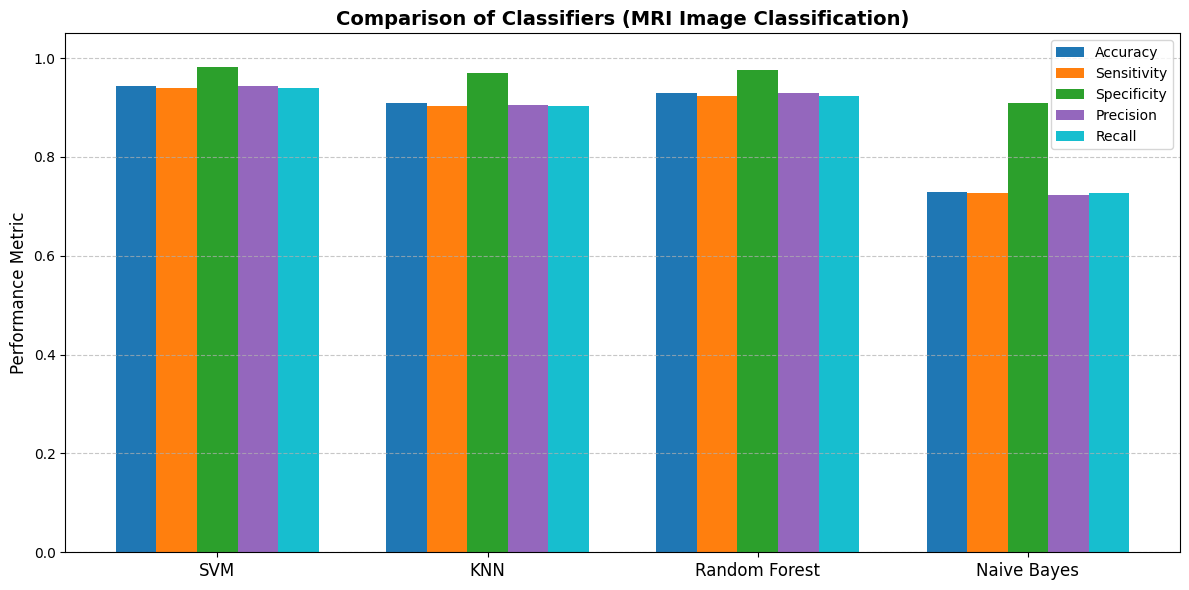

In [18]:
# Bar Graph Comparison

bar_width = 0.15
x = np.arange(len(models))

plt.figure(figsize=(12,6))
plt.bar(x - 2*bar_width, accuracy, width=bar_width, label='Accuracy', color='#1f77b4')
plt.bar(x - bar_width, sensitivity, width=bar_width, label='Sensitivity', color='#ff7f0e')
plt.bar(x, specificity, width=bar_width, label='Specificity', color='#2ca02c')
plt.bar(x + bar_width, precision, width=bar_width, label='Precision', color='#9467bd')
plt.bar(x + 2*bar_width, recall, width=bar_width, label='Recall', color='#17becf')

plt.xticks(x, models, fontsize=12)
plt.ylabel('Performance Metric', fontsize=12)
plt.title('Comparison of Classifiers (MRI Image Classification)', fontsize=14, fontweight='bold')
plt.legend()
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()